In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import pickle as pickle_
import csv

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Popularity Prediction

#### Initialize variables

In [2]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
df_map = {} # to store dfs for each file

#### Reading files into dataframes and storing

In [3]:
import os
df_columns = ['timestamp','tweet_id','author_id','followers','retweets','title','location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                title = j['title']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp,tweet_id,author_id,followers,retweets,title,location])
                line = file_obj.readline()
        else:
            print("File Exists!")
            #writer.close()

Processing  #gopatriots
File Exists!
Processing  #nfl
File Exists!
Processing  #sb49
File Exists!
Processing  #gohawks
File Exists!
Processing  #patriots
File Exists!
Processing  #superbowl
File Exists!


In [4]:
df_map = {}

In [84]:
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')


loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


## 1.1 Statistics

In [158]:
tweets_hrly = {}
retweets_avg = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_avg[hashtag] = (retweets_cnt[hashtag])/tweets_cnt[hashtag]
    followers_hrly[hashtag] = (followers_cnt[hashtag])/tweets_cnt[hashtag]    


#gopatriots
#nfl
#sb49
#gohawks
#patriots
#superbowl


In [38]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_avg)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1348761}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2309.9309809384081}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3221210}
Retweets Avg. hourly {'#gopatriots': 1.4000838670326319, '#nfl': 1.5385331089011056, '#sb49': 2.5111487863247035, '#gohawks': 2.014617085512608, '#patriots': 1.7828156491659402, '#superbowl': 2.3882733857221554}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11948576274.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots'

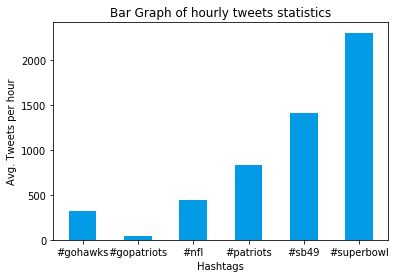

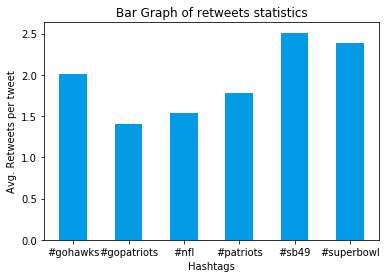

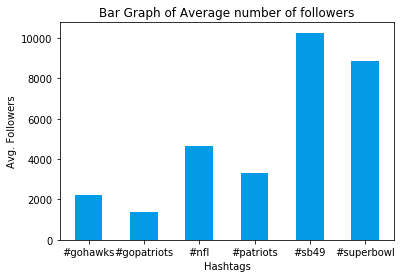

In [159]:
plt.bar(tweets_hrly.keys(),tweets_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of hourly tweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Tweets per hour')
plt.show()
plt.bar(retweets_avg.keys(),retweets_avg.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of retweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Retweets per tweet')
plt.show()
plt.bar(followers_hrly.keys(),followers_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of Average number of followers')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Followers')
plt.show()

#### Returns the hour number from timestamp

In [160]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp/3600)*3600, pst_tz)

#superbowl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00         8
585


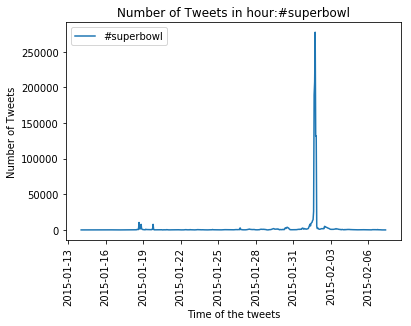

#nfl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00        59
583


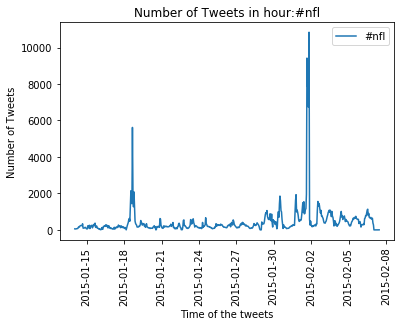

In [205]:
for hashtag in ['#superbowl','#nfl']:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'tweet_id':'count'})
    #grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    
    grouped.reset_index(inplace=True)
    print(grouped.head(1))
    grouped = grouped.sort_values(by=['timestamp'])
    plt.plot(list(grouped['timestamp']),list(grouped['tweet_id']),label=hashtag)
    plt.title('Number of Tweets in hour:'+hashtag)
    print(len(list(grouped['tweet_id'])))
    plt.xticks(rotation=90)
    plt.ylabel('Number of Tweets')
    plt.xlabel('Time of the tweets')
    plt.legend()
    plt.show()


## 1.2 Linear Regression

In [198]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    grouped.reset_index(inplace=True)
    grouped = grouped.sort_values(by=['timestamp'])
    grouped['hour_of_day'] = grouped.apply(lambda x: x['timestamp'].hour, axis=1)
    X_map[hashtag] = grouped.drop(['timestamp'],axis=1)
    print(grouped.head(1))
    Y_map[hashtag] = grouped['tweet_id_count']
    

#gopatriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 02:00:00-07:00        10955.0        10955.0               1   

   retweets_sum  hour_of_day  
0             4            2  
#nfl
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00       104976.0        10658.0              59   

   retweets_sum  hour_of_day  
0            67            1  
#sb49
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 05:00:00-07:00           59.0           59.0               1   

   retweets_sum  hour_of_day  
0             2            5  
#gohawks
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00        24989.0        12922.0              30   

   retweets_sum  hour_of_day  
0           460            1  
#patriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 

#### Method to merge n prev hours

In [227]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    #print(X.head(1))
    col = []
    for i in range(n):
        col = col + [c+'_prev_'+str(n-i)+'_hrs' for c in X.columns ]
    
    X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    #print(len(X_new[:-1]),len(list(y[n:])))
    return pd.DataFrame(X_new[:-1],columns=col),list(y)[n:]

In [235]:
f= open("test_sum/test.csv","w+")
from collections import defaultdict
rmses = defaultdict(list)
for n in range(1,6):
    f.write('\n\n*********'+str(n)+'******\n')
    for hashtag in hashtags:
        f.write('\n\n'+hashtag+'\n')
        #print(hashtag)
        X,y= getprev_n_merged(n,5,X_map[hashtag],Y_map[hashtag])
        model = stats_api.OLS(y,X).fit()
        preds = model.predict(X)
        rmses[hashtag].append(np.sqrt(mean_squared_error(y,preds)))
        print(hashtag,np.sqrt(mean_squared_error(y,preds)))
        #print(model.summary())
        f.write(model.summary().as_csv())
f.close()


#gopatriots 209.888800715
#nfl 586.056935306
#sb49 4642.69132899
#gohawks 978.608408106
#patriots 2527.65168294
#superbowl 8020.16334802
#gopatriots 190.669406015
#nfl 545.787689007
#sb49 4265.81125111
#gohawks 958.153132789
#patriots 2485.96207943
#superbowl 7005.76312275
#gopatriots 122.041076818
#nfl 499.60670342
#sb49 4071.54276557
#gohawks 917.100472165
#patriots 2309.34655206
#superbowl 6455.11124441
#gopatriots 113.888490966
#nfl 494.872379343
#sb49 3933.52844922
#gohawks 890.651100265
#patriots 2229.54912418
#superbowl 6279.49835538
#gopatriots 106.750187275
#nfl 482.322180081
#sb49 3867.69750889
#gohawks 886.560523311
#patriots 2173.34602842
#superbowl 6191.51030615


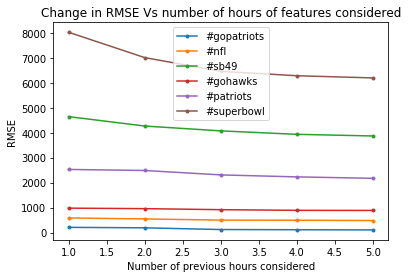

In [245]:
for hashtag in hashtags:
    plt.plot(range(1,6),rmses[hashtag], label=hashtag, marker='.')
#plt.yscale('exponential')
plt.xlabel('Number of previous hours considered')
plt.ylabel('RMSE')
plt.title('Change in RMSE Vs number of hours of features considered')
plt.legend()
plt.show()

# PART 3

In [192]:
def plot_sentiment(hashtags,sentiment_map):
    for hashtag in hashtags:
        plt.title("Total Sentiment : subjectivity*polarity")
        plt.plot(sentiment_map[hashtag]['timestamp'],sentiment_map[hashtag]['sentiment'],label=hashtag)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    for hashtag in hashtags:
        plt.title("Average Total Sentiment : subjectivity*polarity")
        plt.plot(sentiment_map[hashtag]['timestamp'],[(a/b) for a,b in zip(list(sentiment_map[hashtag]['sentiment']),list(sentiment_map[hashtag]['tweet_id'] ))],label=hashtag)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

In [193]:
from textblob import TextBlob as tb
import re
i=0
def clean_tweet(t):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())
def get_sentiment(t):
    global i
    i+=1
    if(i%100000 == 0):
        print(i)
    analysis = tb(clean_tweet(t))
    return analysis.sentiment.polarity*analysis.sentiment.subjectivity
def get_time_bin(t,h):
    return datetime.datetime.fromtimestamp(int(t/(3600*h))*3600*h, pst_tz)    

In [201]:
slist = []

In [202]:
def perform_sentiment_analysis(hashtags,df_map,hrs):
    sentiment_map={}
    for hashtag in hashtags:
        i = 0
        print(hashtag)
        df = df_map[hashtag].copy()
        df['sentiment'] = df['title'].apply(lambda x:get_sentiment(x))
        df['timestamp'] = df['timestamp'].apply(lambda x:get_time_bin(x,hrs) )
        grouped = df.groupby('timestamp').agg({'sentiment':'sum','tweet_id':'count'})
        grouped.reset_index(inplace=True)
        grouped = grouped.sort_values(by=['timestamp'])
        sentiment_map[hashtag]=grouped
    plot_sentiment(hashtags,sentiment_map)
    return sentiment_map    

#gopatriots
15700000
#nfl
15800000
15900000
#sb49
16000000
16100000
16200000
16300000
16400000
16500000
16600000
16700000
16800000
#gohawks
16900000
#patriots
17000000
17100000
17200000
17300000
17400000
#superbowl
17500000
17600000
17700000
17800000
17900000
18000000
18100000
18200000
18300000
18400000
18500000
18600000
18700000
18800000


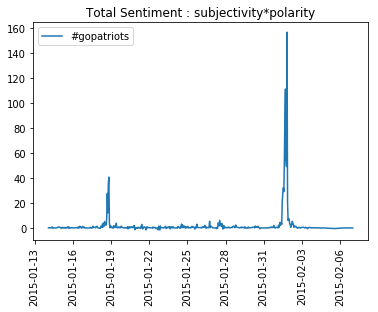

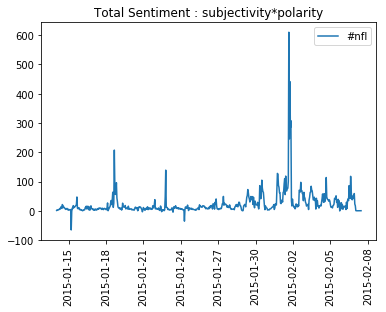

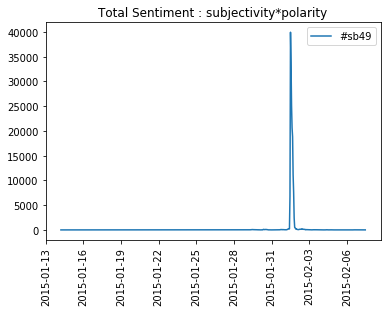

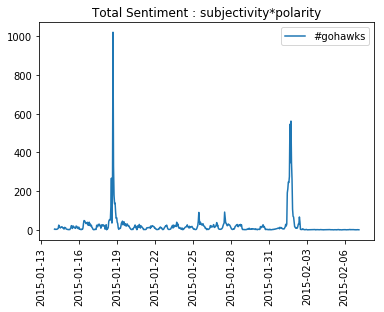

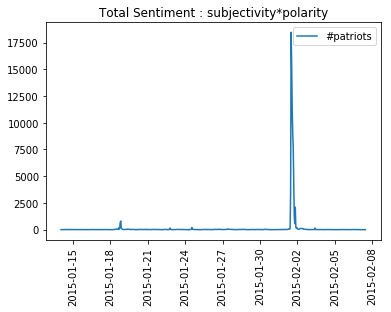

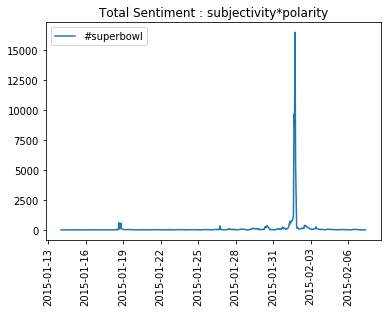

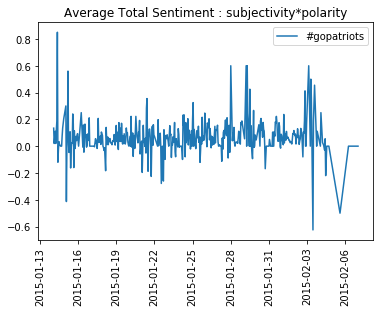

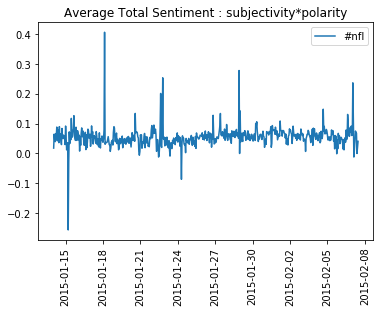

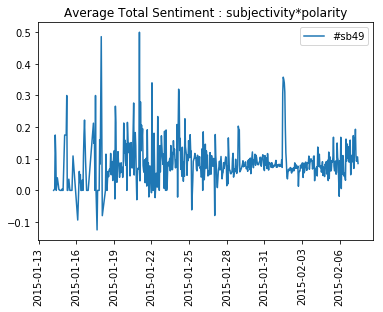

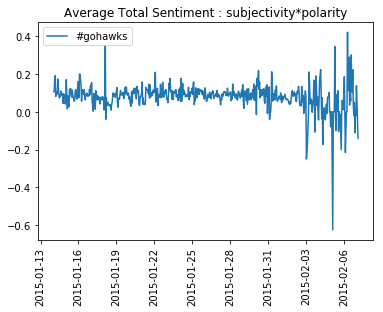

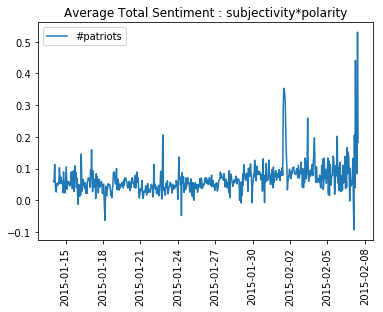

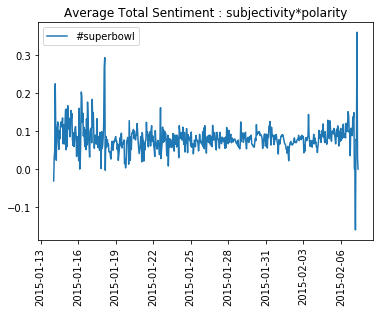

#gopatriots
#nfl
18900000
19000000
19100000
#sb49
19200000
19300000
19400000
19500000
19600000
19700000
19800000
19900000
#gohawks
20000000
20100000
#patriots
20200000
20300000
20400000
20500000
20600000
#superbowl
20700000
20800000
20900000
21000000
21100000
21200000
21300000
21400000
21500000
21600000
21700000
21800000
21900000


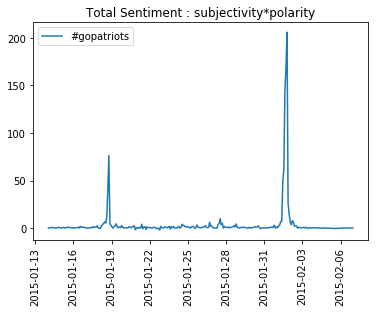

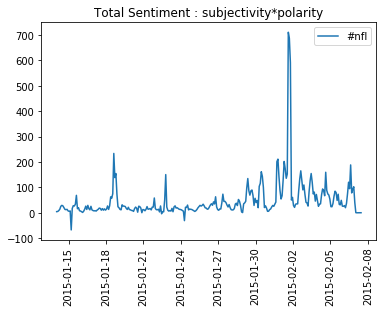

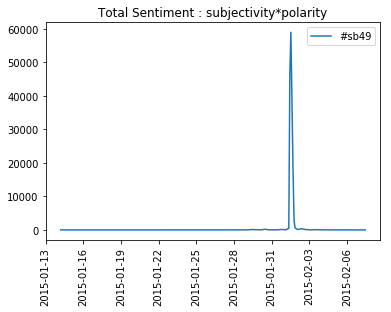

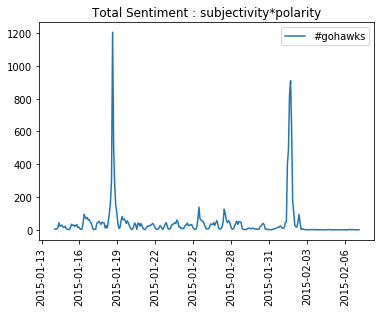

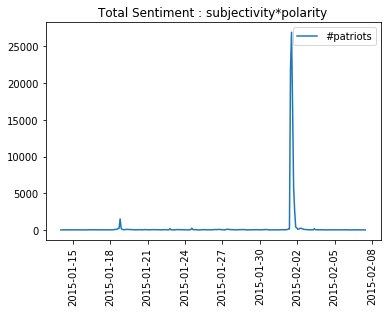

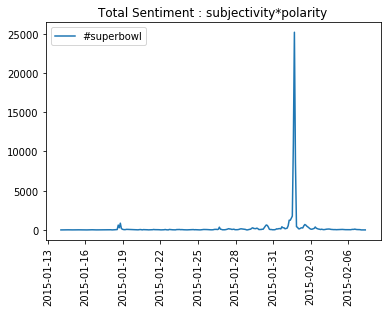

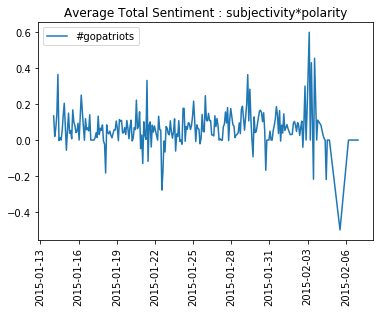

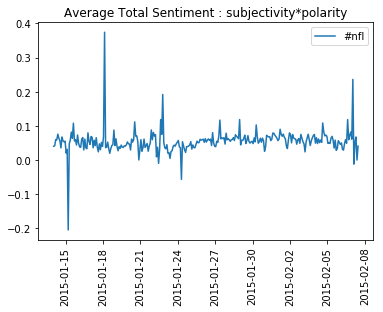

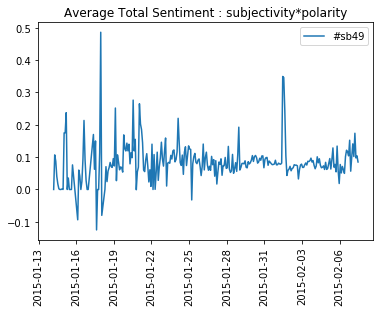

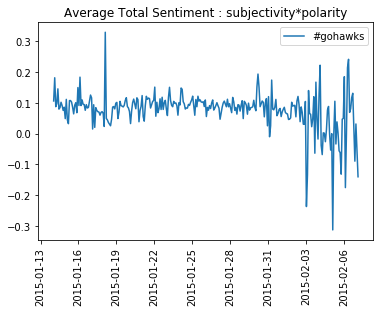

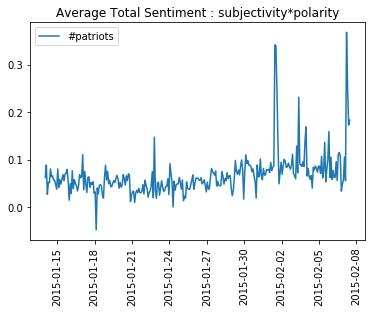

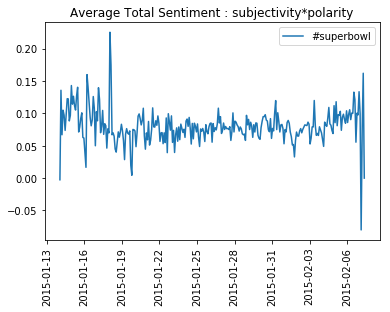

#gopatriots
#nfl
22000000
22100000
22200000
#sb49
22300000
22400000
22500000
22600000
22700000
22800000
22900000
23000000
#gohawks
23100000
23200000
#patriots
23300000
23400000
23500000
23600000
23700000
#superbowl
23800000
23900000
24000000
24100000
24200000
24300000
24400000
24500000
24600000
24700000
24800000
24900000
25000000
25100000


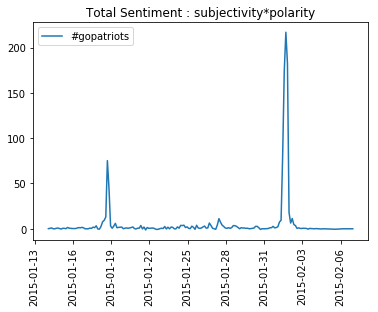

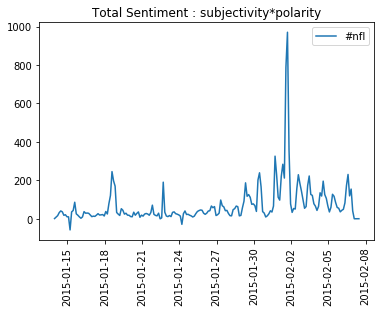

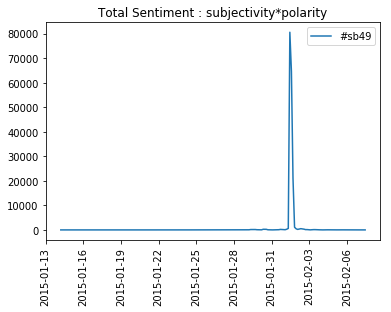

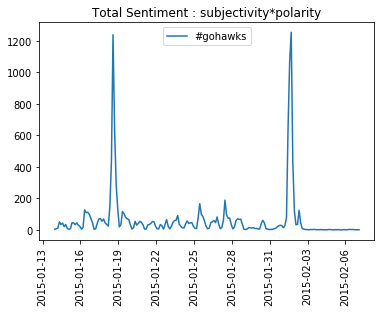

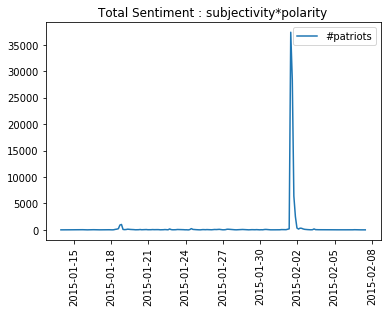

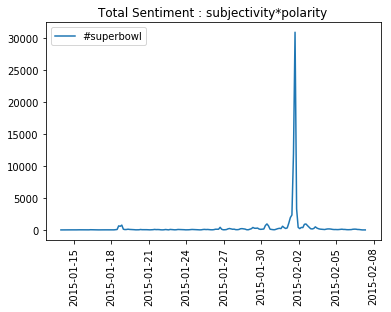

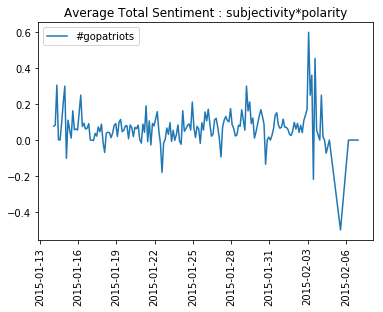

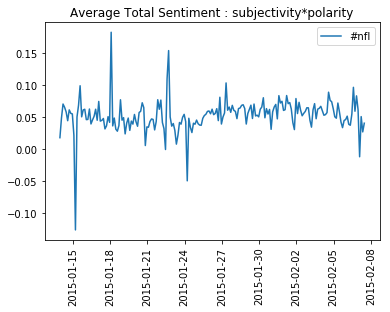

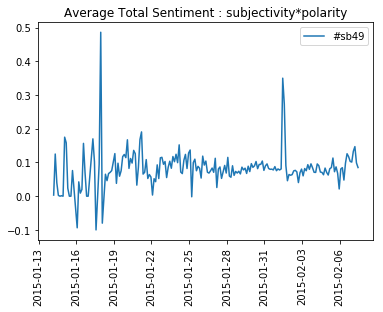

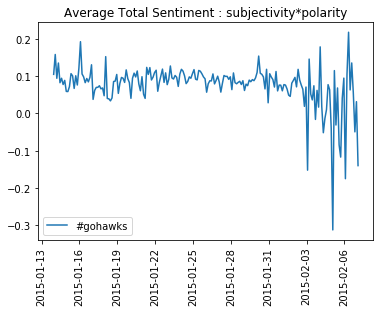

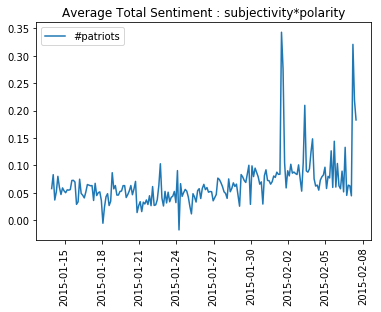

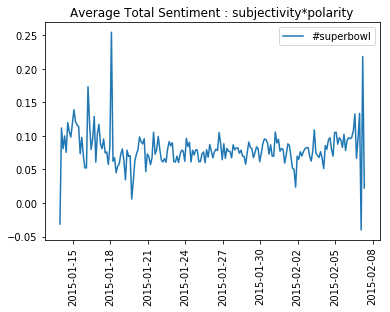

#gopatriots
#nfl
25200000
25300000
#sb49
25400000
25500000
25600000
25700000
25800000
25900000
26000000
26100000
26200000
#gohawks
26300000
26400000
#patriots
26500000
26600000
26700000
26800000
26900000
#superbowl
27000000
27100000
27200000
27300000
27400000
27500000
27600000
27700000
27800000
27900000
28000000
28100000
28200000


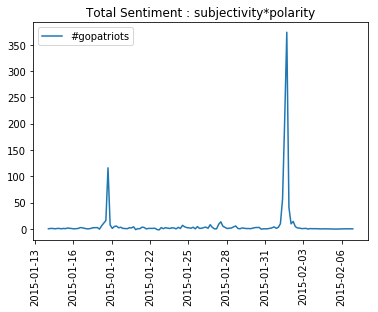

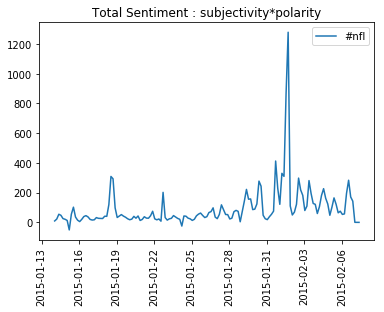

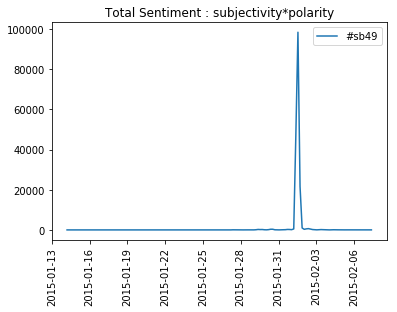

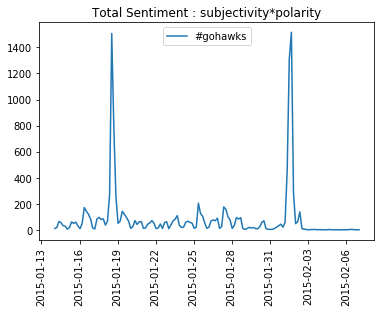

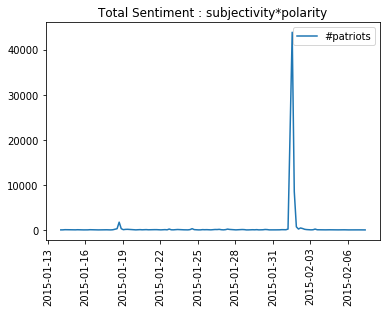

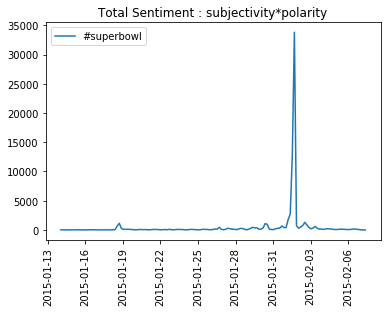

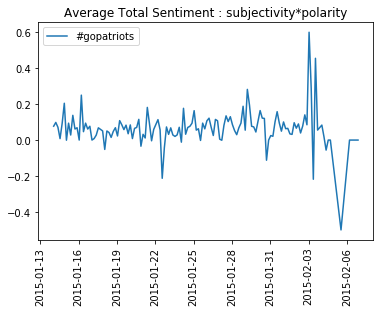

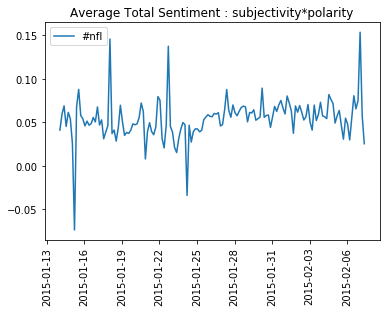

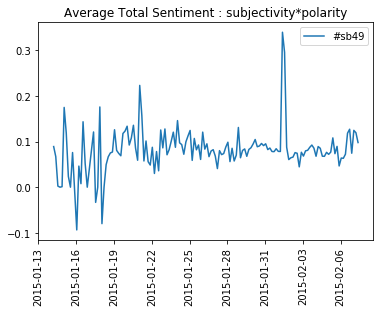

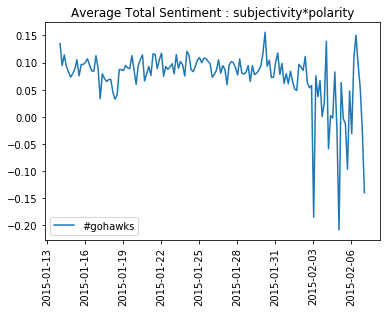

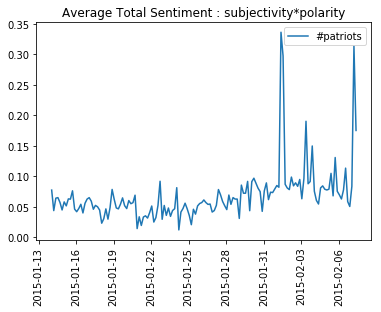

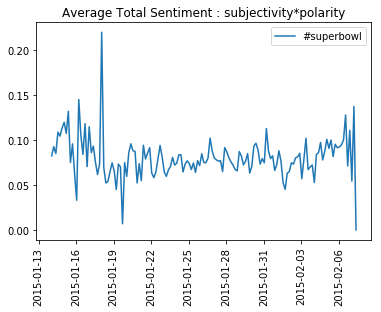

#gopatriots
#nfl
28300000
28400000
28500000
#sb49
28600000
28700000
28800000
28900000
29000000
29100000
29200000
29300000
#gohawks
29400000
29500000
#patriots
29600000
29700000
29800000
29900000
30000000
#superbowl
30100000
30200000
30300000
30400000
30500000
30600000
30700000
30800000
30900000
31000000
31100000
31200000
31300000


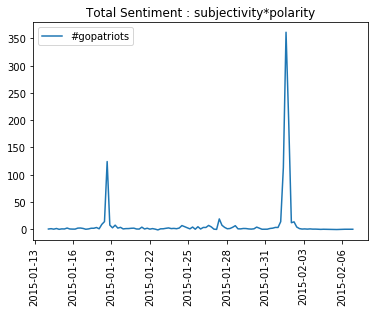

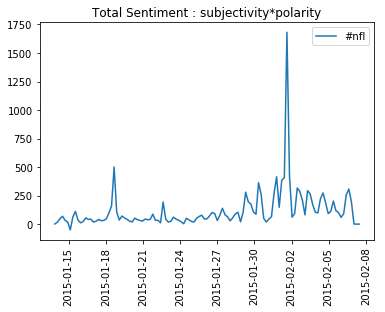

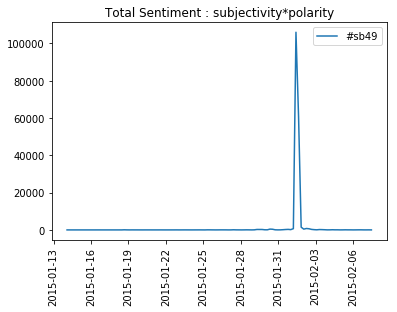

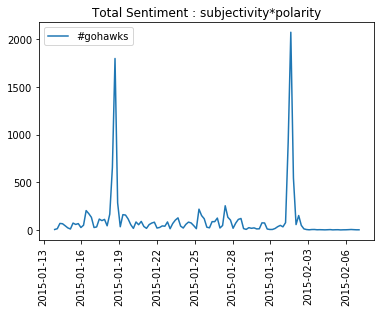

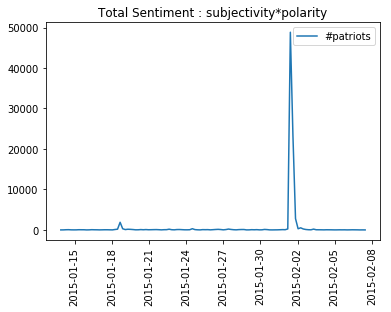

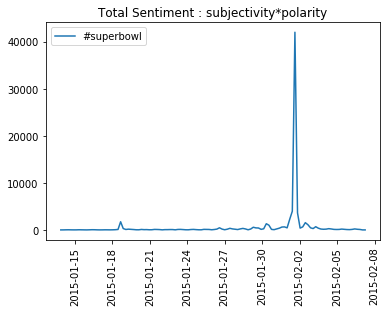

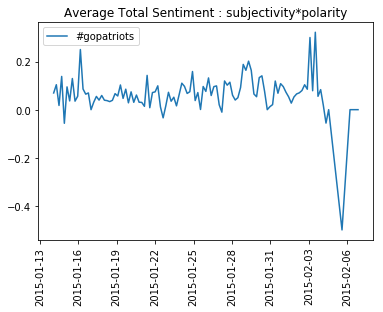

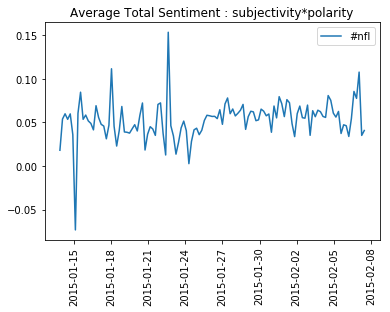

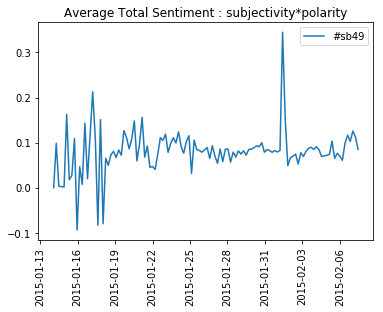

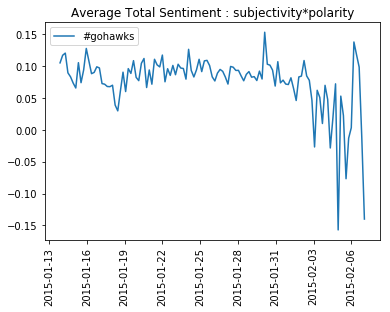

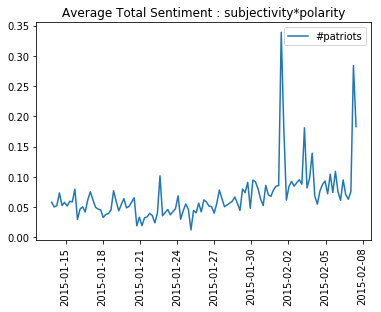

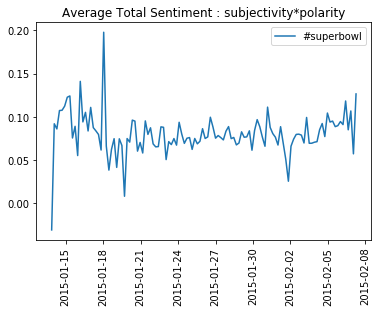

In [203]:
for hrs in range(1,6):
    slist.append(perform_sentiment_analysis(hashtags,df_map,hrs))

Hours: 9
#gopatriots
31400000
#nfl
31500000
31600000
#sb49
31700000
31800000
31900000
32000000
32100000
32200000
32300000
32400000
32500000
#gohawks
32600000
#patriots
32700000
32800000
32900000
33000000
33100000
#superbowl
33200000
33300000
33400000
33500000
33600000
33700000
33800000
33900000
34000000
34100000
34200000
34300000
34400000
34500000


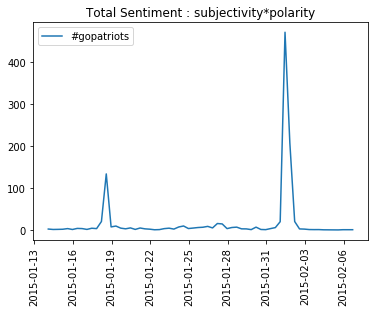

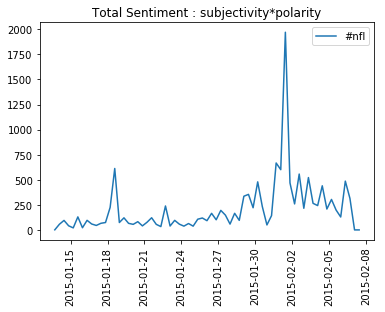

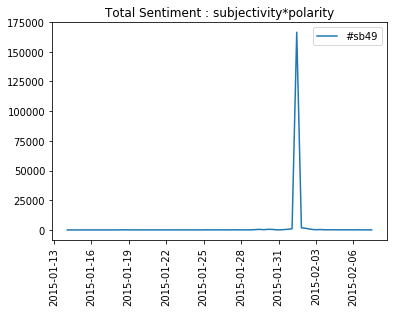

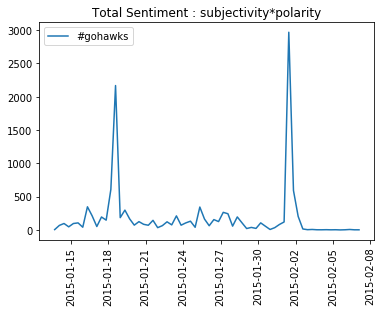

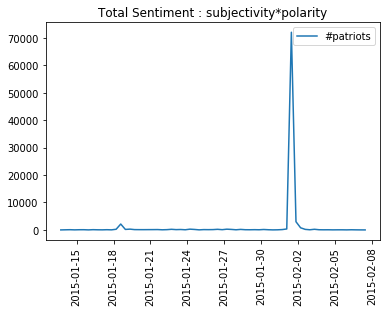

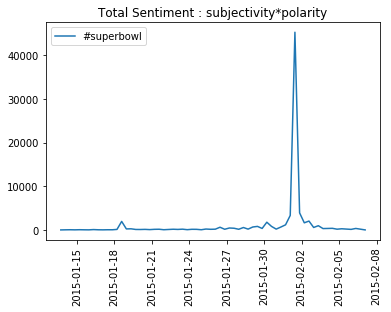

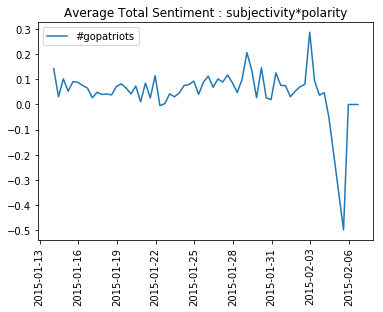

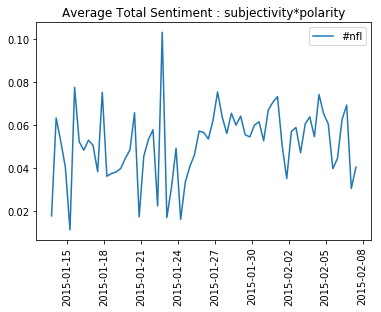

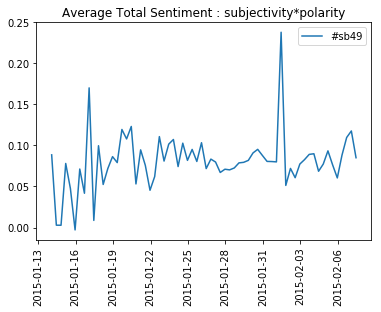

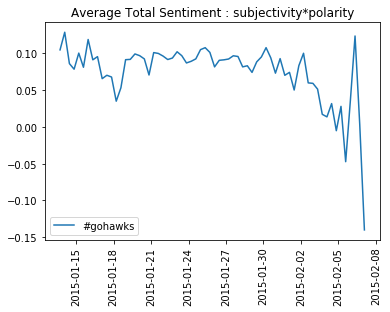

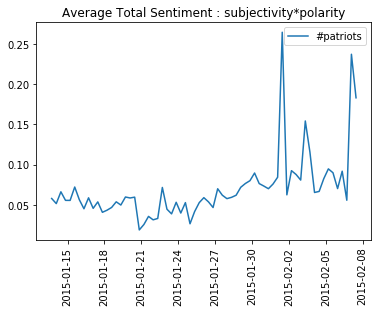

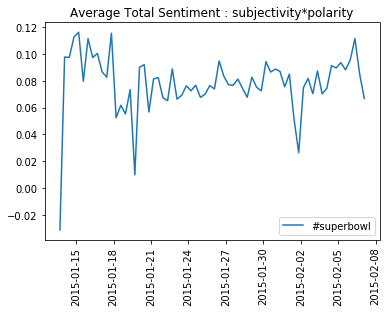

Hours: 12
#gopatriots
#nfl
34600000
34700000
34800000
#sb49
34900000
35000000
35100000
35200000
35300000
35400000
35500000
35600000
#gohawks
35700000
35800000
#patriots
35900000
36000000
36100000
36200000
36300000
#superbowl
36400000
36500000
36600000
36700000
36800000
36900000
37000000
37100000
37200000
37300000
37400000
37500000
37600000


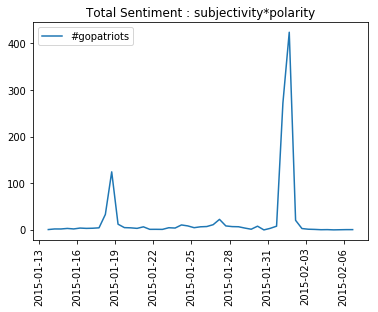

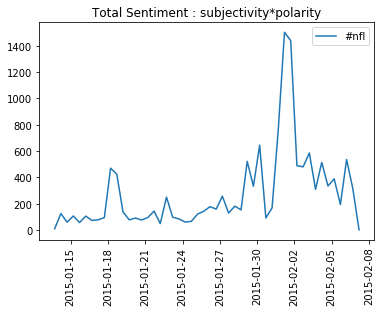

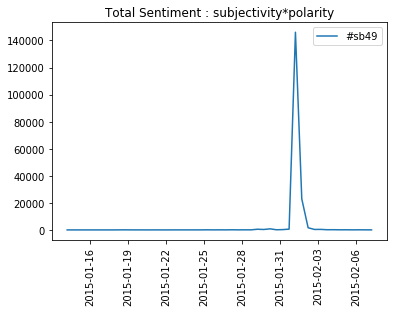

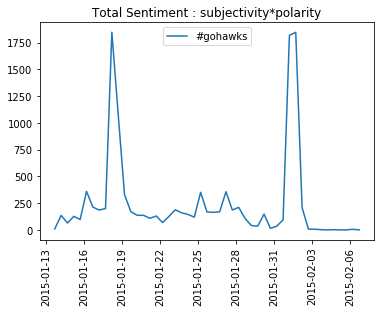

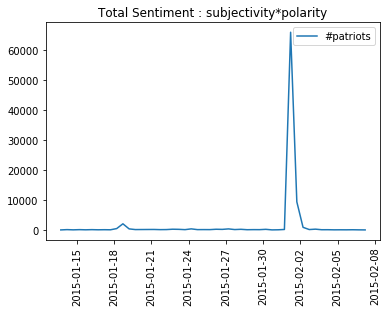

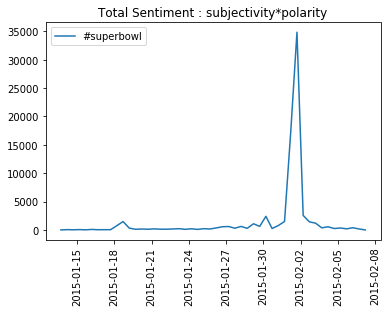

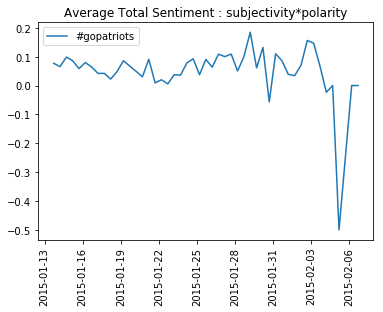

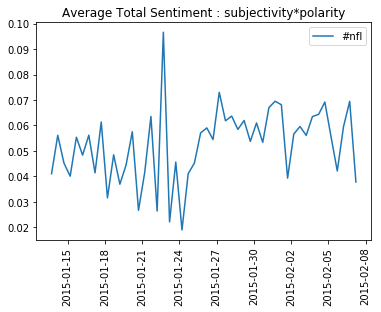

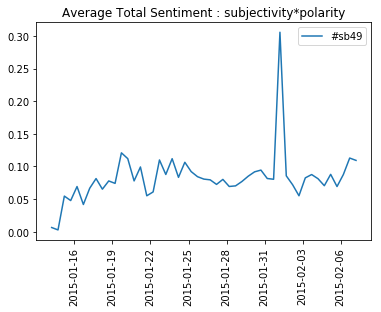

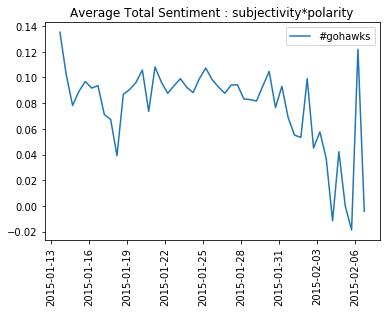

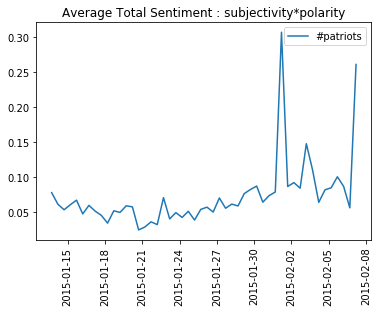

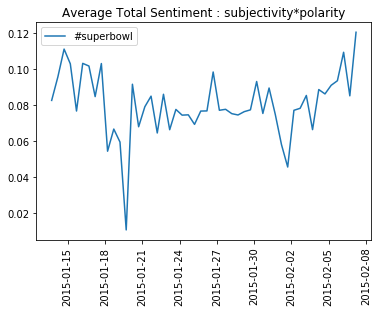

Hours: 15
#gopatriots
#nfl
37700000
37800000
37900000
#sb49
38000000
38100000
38200000
38300000
38400000
38500000
38600000
38700000
#gohawks
38800000
38900000
#patriots
39000000
39100000
39200000
39300000
39400000
#superbowl
39500000
39600000
39700000
39800000
39900000
40000000
40100000
40200000
40300000
40400000
40500000
40600000
40700000
40800000


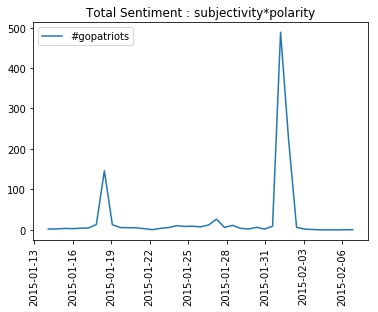

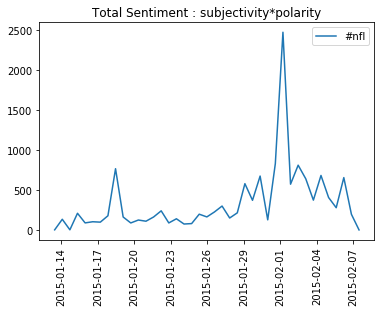

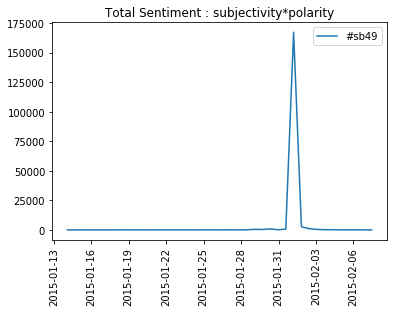

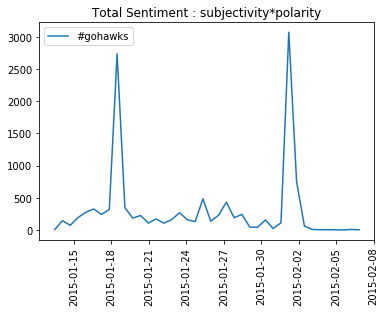

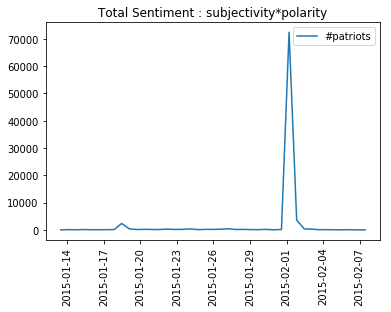

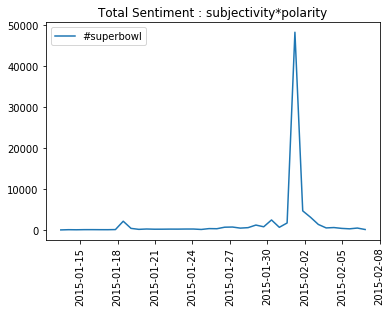

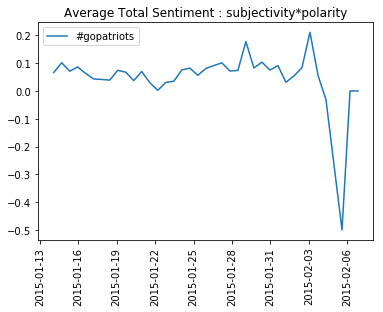

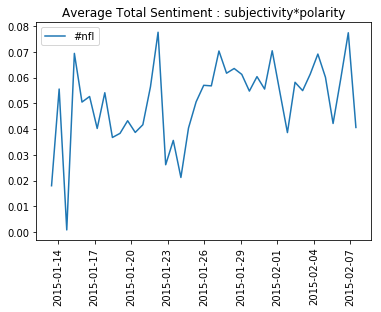

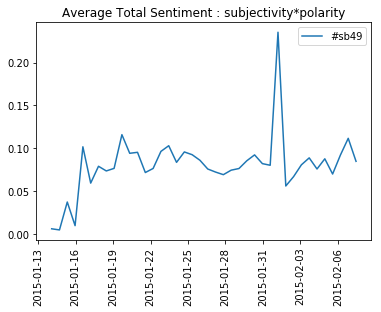

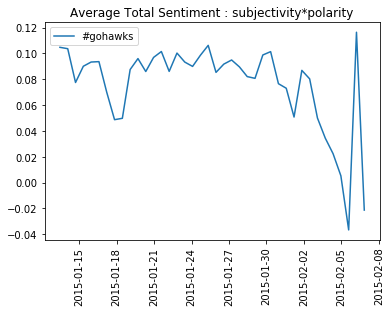

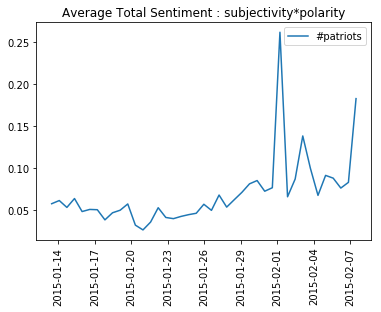

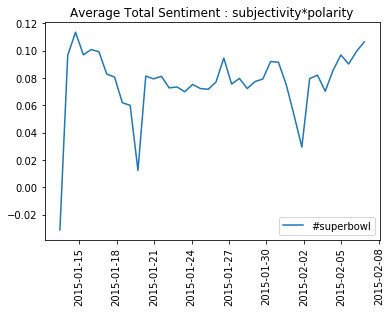

Hours: 18
#gopatriots
#nfl
40900000
41000000
#sb49
41100000
41200000
41300000
41400000
41500000
41600000
41700000
41800000
41900000
#gohawks
42000000
42100000
#patriots
42200000
42300000
42400000
42500000
#superbowl
42600000
42700000
42800000
42900000
43000000
43100000
43200000
43300000
43400000
43500000
43600000
43700000
43800000
43900000


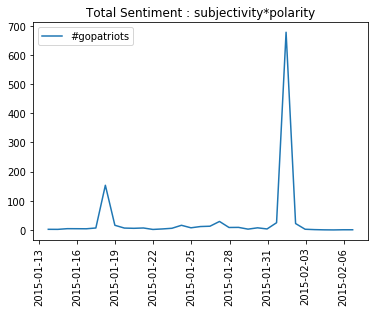

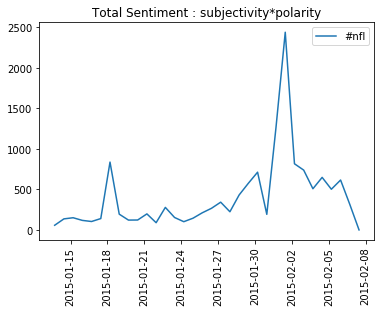

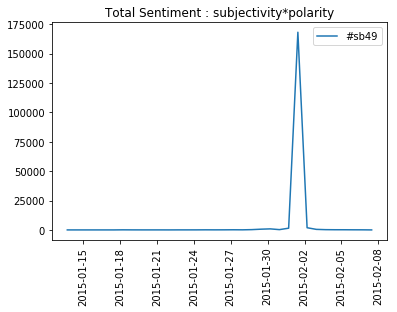

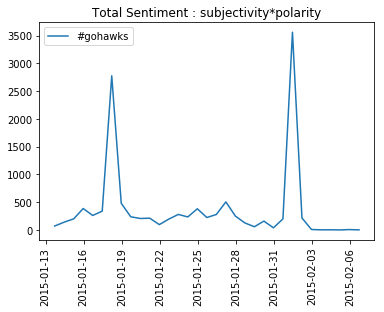

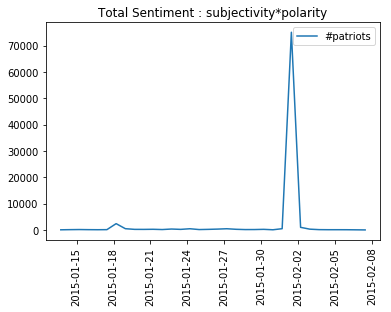

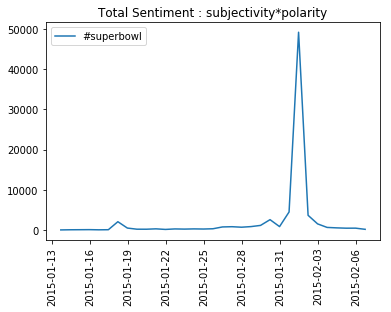

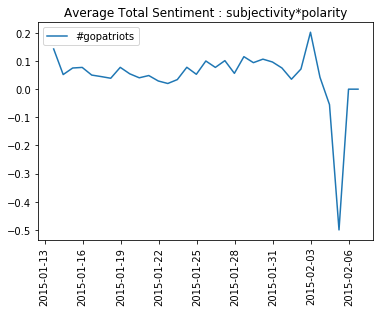

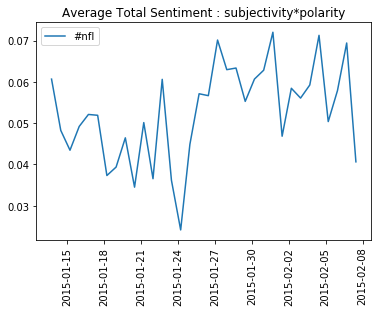

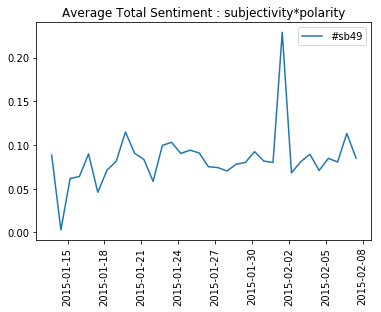

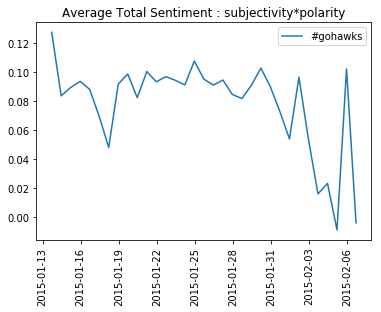

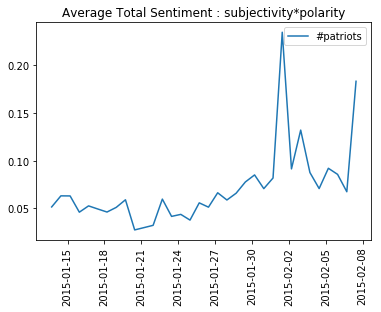

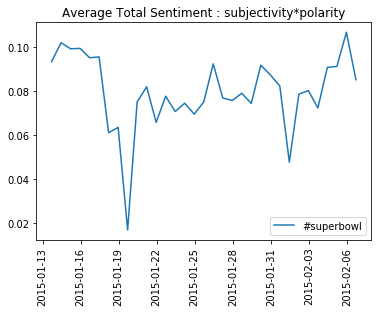

Hours: 21
#gopatriots
#nfl
44000000
44100000
44200000
#sb49
44300000
44400000


KeyboardInterrupt: 

In [204]:
for hrs in range(9,24,3):
    print("Hours:",hrs)
    slist.append(perform_sentiment_analysis(hashtags,df_map,hrs))